In [1]:
from dolfin import * 
%matplotlib inline
import matplotlib.pyplot as plt
import logging; 

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)

def generate_matrices(epsilon, beta, N, vis = False):

	mesh = UnitIntervalMesh(N);
	V = FunctionSpace(mesh,"CG",1);

	u = TrialFunction(V); v = TestFunction(V)
	u0 = Constant(0.0); u1 = Constant(1.0)

	def left_boundary(x):
		return x[0] < DOLFIN_EPS 

	def right_boundary(x):
		return x[0] > 1.0 - DOLFIN_EPS

	f = Constant(0.0)
	h = mesh.hmin()

	a = -Constant(beta)*u.dx(0)*v*dx - epsilon*u.dx(0)*v.dx(0)*dx
	L = f*v*dx


	bcs = [DirichletBC(V, u0, left_boundary), DirichletBC(V, u1, right_boundary)]
	A,b = assemble_system(a,L,bcs)

	U = Function(V)
	solve(A, U.vector(), b)

	A_mat = as_backend_type(A).mat(); 
	from scipy.sparse import csr_matrix
	As = csr_matrix(A_mat.getValuesCSR()[::-1], shape = A_mat.size)

	return As.toarray(),b.array()

def visualize_solution(x):
	
	N = np.size(x) - 1
	mesh = UnitIntervalMesh(N);
	V = FunctionSpace(mesh,"CG",1);
	uex = Expression("(exp(x[0]*(beta/epsilon)) - 1)/(exp((beta/epsilon)) - 1)", beta = beta, epsilon = epsilon)
	Uex = project(uex,V)
	import matplotlib.pyplot as plt
	plt.plot(mesh.coordinates(),x)
	plt.plot(mesh.coordinates(),Uex.vector().array())
	plt.legend(["Numerical Solution", "Analytical Solution"])
	plt.xlabel('x')
	plt.ylabel('u')
	plt.show()

In [2]:
import numpy as np 
N = 60
beta = 1; epsilon = 1e-2
A,b = generate_matrices(epsilon,beta,N)
x = np.linalg.solve(A,b) 


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


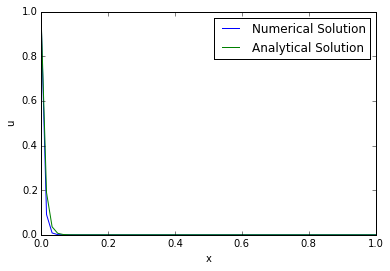

In [3]:
visualize_solution(x)

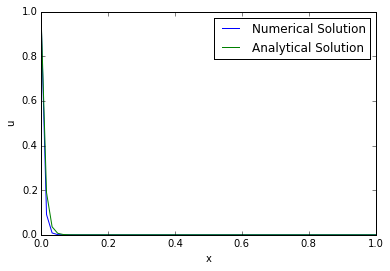

In [4]:
[m,n] = np.shape(A)
x_jacobi = np.zeros(np.shape(b));
maxit = 20; 
nm = np.zeros((maxit,1))

D = np.diag(np.diag(A))
R = A - D
Dinvb = np.linalg.solve(D,b)
for k in np.arange(maxit):
	x_jacobi = Dinvb - np.linalg.solve(D,np.dot(R,x_jacobi) )
	nm[k] = np.linalg.norm(np.dot(A,x_jacobi)-b)
visualize_solution(x_jacobi)


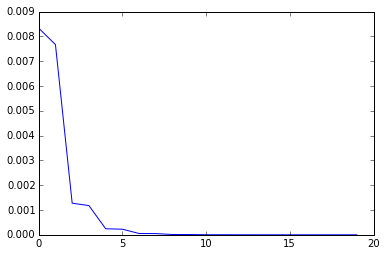

In [5]:
plt.plot(nm)
plt.show()

In [6]:
T = np.linalg.solve(-D,R)
eigsT, _ = np.linalg.eig(T)
rho =  np.max(np.abs(eigsT))
print rho

0.630090418107
